In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import logging


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from app.helpers.finetuning.training import train_per_protein, score_sequences
from app.helpers.sequence_util import (
    get_seq_ids_for_deep_mutational_scan,
    seq_id_to_seq,
    maybe_get_seq_id_error_message,
    process_and_validate_evolve_input_files,
)


In [3]:
import pandas as pd
import re

rubisco_wt_aa_seq = 'MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFAAESSTGTNVEVCTTDDFTRGVDALVYEVDEARELTKIAYPVALFDRNITDGKAMIASFLTLTMGNNQGMGDVEYAKMHDFYVPEAYRALFDGPSVNISALWKVLGRPEVDGGLVVGTIIKPKLGLRPKPFAEACHAFWLGGDFIKNDEPQGNQPFAPLRDTIALVADAMRRAQDETGEAKLFSANITADDPFEIIARGEYVLETFGENASHVALLVDGYVAGAAAITTARRRFPDNFLHYHRAGHGAVTSPQSKRGYTAFVHCKMARLQGASGIHTGTMGFGKMEGESSDRAIAYMLTQDEAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTAGGGAFGHIDGPVAGARSLRQAWQAWRDGVPVLDYAREHKELARAFESFPGDADQIYPGWRKALGVEDTRSALPA'
rubisco_activity = pd.read_csv('notebooks/data/rubisco_activity.csv')
rubisco_activity = rubisco_activity.rename(columns={'mutant': 'seq_id', 'Fitness': 'activity'})[['seq_id', 'activity']]

tem1_activity = pd.read_excel('notebooks/data/tem1_activity.xlsx', sheet_name='simplified')
tem1_activity = tem1_activity.rename(columns={'Mutation': 'seq_id', 'activity_at_2500': 'activity'})[['seq_id', 'activity']]
def fix_tem1_seq_id(seq_id):
  m = re.match(r'([A-Z])(\d+)(.*)', seq_id)
  assert m, seq_id
  old_id = m.groups()[0]
  locus = int(m.groups()[1])
  new_id = m.groups()[2]

  new_locus = locus - 2
  
  if new_locus >= 245:
    new_locus = new_locus - 2

  return f'{old_id}{new_locus}{new_id}'
tem1_activity['seq_id'] = tem1_activity.seq_id.apply(fix_tem1_seq_id)


Text(0.5, 1.0, 'ESM2-650M-0, Spearman: 0.67')

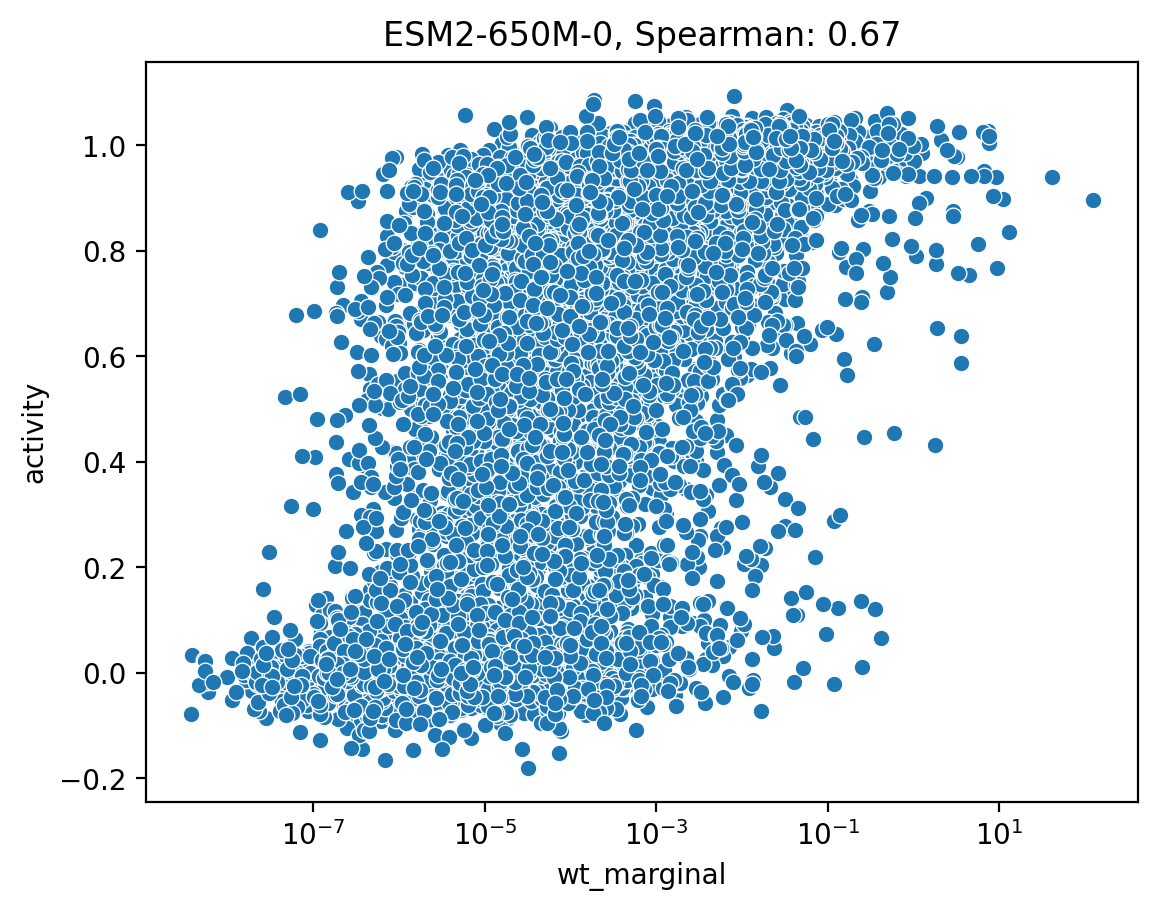

In [8]:
from scipy.stats import spearmanr
import seaborn as sns
from matplotlib import pyplot as plt

# Load in fine=tuned predictions.
ensemble_scores = pd.read_csv('notebooks/data/ensemble_results.ipynb/logits_rubisco_emsemble_melted.csv')
mean_scores = ensemble_scores.groupby('seq_id')['wt_marginal'].mean()
combined_mean_df = pd.merge(rubisco_activity, mean_scores, on='seq_id', how='inner')

sns.scatterplot(x='wt_marginal', y='activity', data=combined_mean_df)
plt.xscale('log')
spearman = spearmanr(combined_mean_df.wt_marginal, combined_mean_df.activity)
plt.title(f'ESM2-650M-0, Spearman: {spearman.correlation:.2f}')

In [ ]:
ensemble_scores.groupby('seq_id')['wt_marginal'].mean()

<Axes: title={'center': 'ESM2-650M-0, Spearman: 0.10'}, xlabel='exceeds_unity', ylabel='activity'>

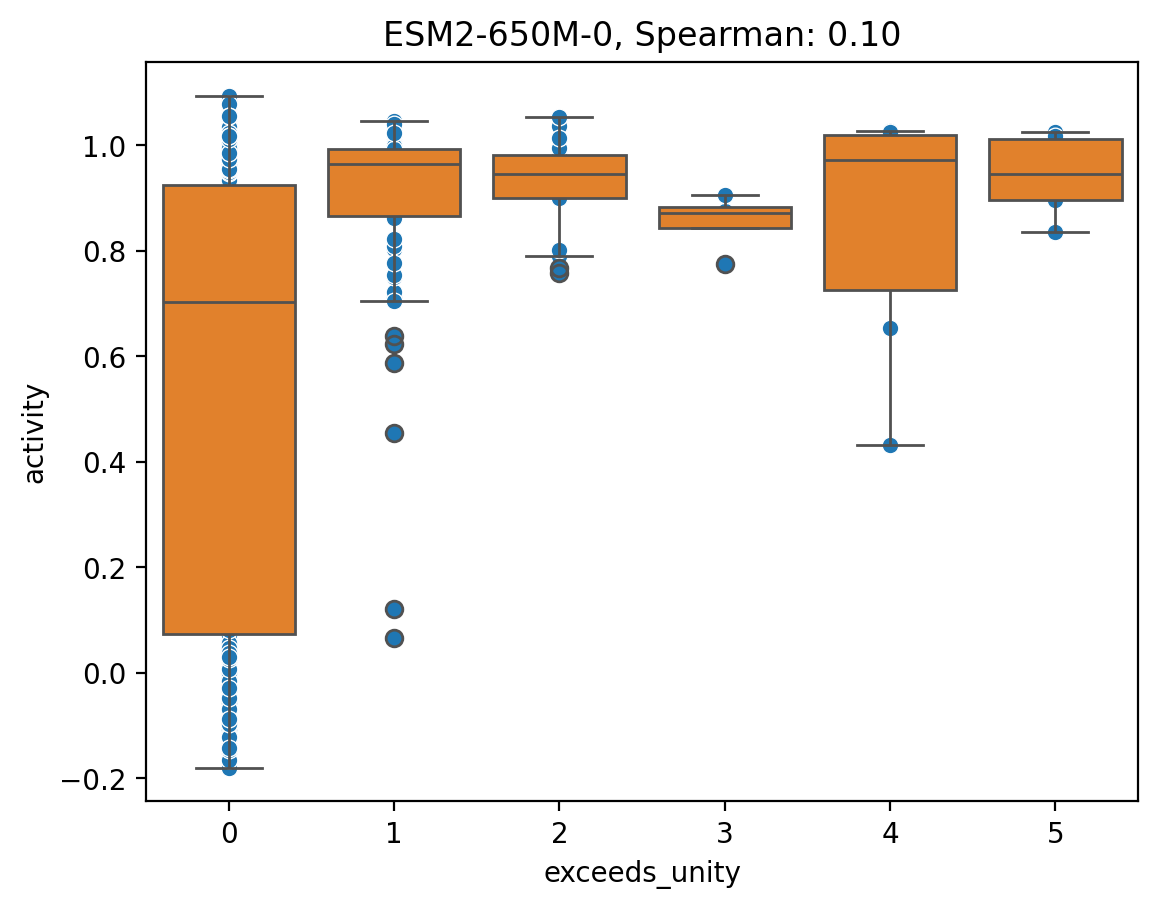

In [ ]:
from scipy.stats import spearmanr
import seaborn as sns
from matplotlib import pyplot as plt

# Load in fine=tuned predictions.
ensemble_scores = pd.read_csv('notebooks/data/ensemble_results.ipynb/logits_rubisco_emsemble_melted.csv')
ensemble_scores['exceeds_unity'] = ensemble_scores['wt_marginal'] > 1
consensus_scores = ensemble_scores.groupby('seq_id')['exceeds_unity'].sum()
combined_mean_df = pd.merge(rubisco_activity, consensus_scores, on='seq_id', how='inner')

sns.scatterplot(x='exceeds_unity', y='activity', data=combined_mean_df)
# plt.xscale('log')
spearman = spearmanr(combined_mean_df.exceeds_unity, combined_mean_df.activity)
plt.title(f'ESM2-650M-0, Spearman: {spearman.correlation:.2f}')

# sns.boxplot(x='exceeds_unity', y='activity', data=combined_mean_df)

# I want to compare two distributions in a boxplot

T-test p-value: 0.5038


<Axes: title={'center': 'Activity Distribution by Prediction Method (16 mutants, RuBisCO)'}, xlabel='method', ylabel='activity'>

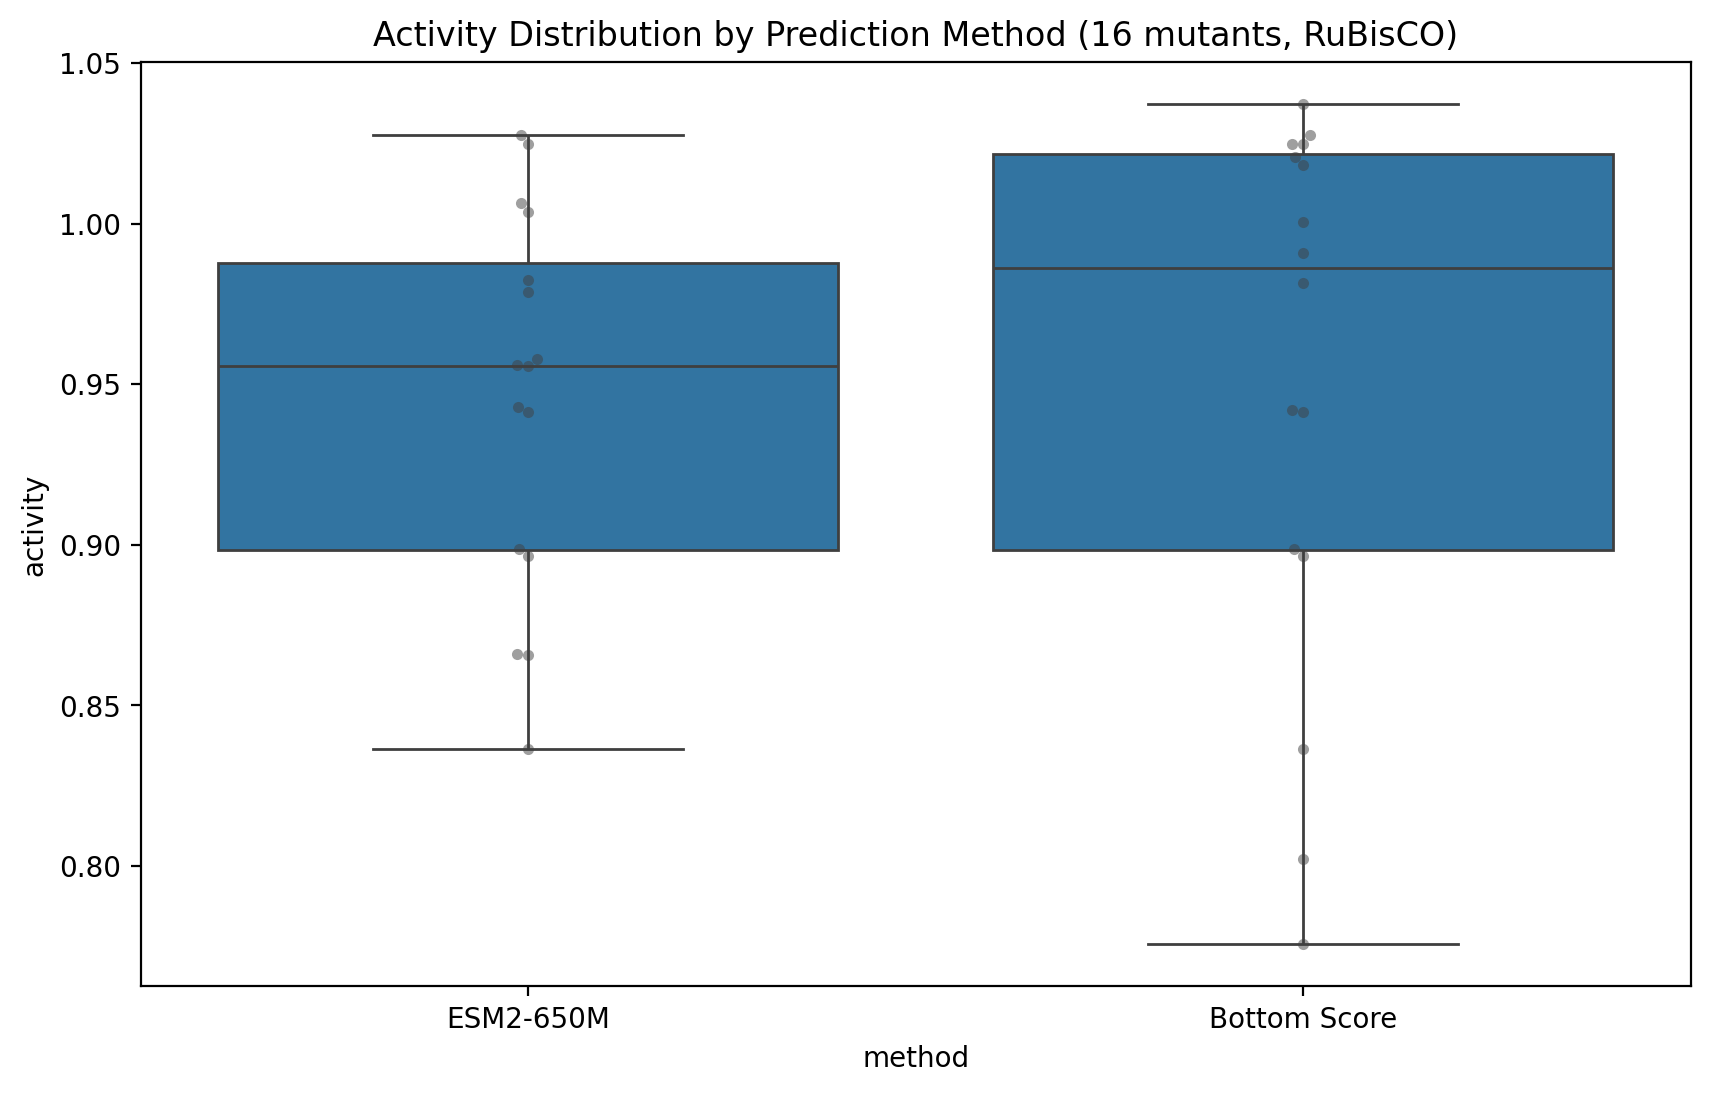

In [23]:
from scipy.stats import spearmanr
import seaborn as sns
from matplotlib import pyplot as plt

NUM_MUTANTS = 16
TARGET = 'RuBisCO'

# Create different prediction methods and combine them into a long format DataFrame
ensemble_scores = pd.read_csv('notebooks/data/ensemble_results.ipynb/logits_rubisco_emsemble_melted.csv')

# Method: Mean of wt_marginal
# mean_scores = ensemble_scores.groupby('seq_id')['wt_marginal'].mean()
# mean_df = pd.merge(rubisco_activity, mean_scores, on='seq_id', how='inner')
random_df = rubisco_activity.sample(NUM_MUTANTS)
random_df['method'] = 'Random'

# Method: Mean of wt_marginal
mean_scores = ensemble_scores.groupby('seq_id')['wt_marginal'].mean()
mean_df = pd.merge(rubisco_activity, mean_scores, on='seq_id', how='inner')
mean_df = mean_df.sort_values(by='wt_marginal', ascending=False)[:NUM_MUTANTS]
mean_df['method'] = 'Mean Score'

# Method: Max of wt_marginal
max_scores = ensemble_scores.groupby('seq_id')['wt_marginal'].max()
max_df = pd.merge(rubisco_activity, max_scores, on='seq_id', how='inner')
max_df = max_df.sort_values(by='wt_marginal', ascending=False)[:NUM_MUTANTS]
max_df['method'] = 'Top Score'

# Method: Min of wt_marginal
min_scores = ensemble_scores.groupby('seq_id')['wt_marginal'].min()
min_df = pd.merge(rubisco_activity, min_scores, on='seq_id', how='inner')
min_df = min_df.sort_values(by='wt_marginal', ascending=False)[:NUM_MUTANTS]
min_df['method'] = 'Bottom Score'

# Method: Consensus voting (exceeds unity count)
consensus_scores = ensemble_scores.groupby('seq_id')['wt_marginal'].apply(lambda x: (x > 1).sum())
consensus_df = pd.merge(rubisco_activity, consensus_scores, on='seq_id', how='inner')
consensus_df = consensus_df.sort_values(by='wt_marginal', ascending=False)[:NUM_MUTANTS]
consensus_df['method'] = 'Consensus Vote'

# Methods: 650M
esm2_scores = pd.read_csv('notebooks/finetuning_results/logits_rubisco_ESM2-650M_melted.csv')
esm2_df = pd.merge(rubisco_activity, esm2_scores, on='seq_id', how='inner')
esm2_df = esm2_df.sort_values(by='wt_marginal', ascending=False)[:NUM_MUTANTS]
esm2_df['method'] = 'ESM2-650M'

# Method: ESM3 300M
esm3_scores = pd.read_csv('notebooks/data/ensemble_results.ipynb/logits_rubisco_300_melted.csv')
esm3_df = pd.merge(rubisco_activity, esm3_scores, on='seq_id', how='inner')
esm3_df = esm3_df.sort_values(by='wt_marginal', ascending=False)[:NUM_MUTANTS]
esm3_df['method'] = 'ESM3-300M'

# Method: ESM2 with aggressive finetuning
finetuning_scores = pd.read_csv('notebooks/finetuning_results/scores_ft650m1000-0227_epochs=1_learningrate=0.0001.csv')\
  .rename(columns={'wt_marginal_score': 'wt_marginal'})
finetuning_df = pd.merge(rubisco_activity, finetuning_scores, on='seq_id', how='inner')
finetuning_df = finetuning_df.sort_values(by='wt_marginal', ascending=False)[:NUM_MUTANTS]
finetuning_df['method'] = 'ESM2-650M FT'

# Combine into long format
combined_long = pd.concat([
    # random_df[['seq_id', 'activity', 'method']],
    esm2_df[['seq_id', 'activity', 'method']],
    # finetuning_df[['seq_id', 'activity', 'method']],
    # esm3_df[['seq_id', 'activity', 'method']],
    # mean_df[['seq_id', 'activity', 'method']],
    # max_df[['seq_id', 'activity', 'method']],
    min_df[['seq_id', 'activity', 'method']],
    # consensus_df[['seq_id', 'activity', 'method']],
])

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_long, x='method', y='activity')
plt.title(f'Activity Distribution by Prediction Method ({NUM_MUTANTS} mutants, {TARGET})')

# Add statistical comparison
from scipy import stats
mean_activities = mean_df['activity']
consensus_activities = consensus_df['activity']
ttest_result = stats.ttest_ind(mean_activities, consensus_activities)
print(f"T-test p-value: {ttest_result.pvalue:.4f}")

# Optional: Add swarmplot to see individual points
sns.swarmplot(data=combined_long, x='method', y='activity', color='0.25', alpha=0.5, size=4)